In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
train_path="data/all_updated1/train"
test_path="data/all_updated1/test"
val_path="data/all_updated1/val"

In [3]:
# Image preprocessing using VGG-19 model

# resize images to 224x224 and store in array

x_train=[]
for folder in os.listdir(train_path):
    if (folder != ".DS_Store"):
        sub_path=train_path+"/"+folder
        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            if img_arr is None:
                continue
            else:
                img_arr=cv2.resize(img_arr,(224,224))
                x_train.append(img_arr)

x_test=[]
for folder in os.listdir(test_path):
    if (folder != ".DS_Store"):
        sub_path=test_path+"/"+folder
        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            if img_arr is None:
                continue
            else:
                img_arr=cv2.resize(img_arr,(224,224))
                x_test.append(img_arr)
                
x_val=[]
for folder in os.listdir(val_path):
    if (folder != ".DS_Store"):
        sub_path=val_path+"/"+folder
        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            if img_arr is None:
                continue
            else:
                img_arr=cv2.resize(img_arr,(224,224))
                x_val.append(img_arr)
                

In [4]:
# divide by 255 to normalize
train_x=np.array(x_train)/255.0
test_x=np.array(x_test)/255.0
val_x=np.array(x_val)/255.0


In [5]:
# Compute labels of corresponding datasets
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# generate batches of augmented data
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 504 images belonging to 3 classes.
Found 148 images belonging to 3 classes.
Found 149 images belonging to 3 classes.


In [6]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [7]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((504,), (148,), (149,))

In [8]:
# Model Building
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# We will not train the pre-trained layers
for layer in vgg.layers:
    layer.trainable = False

2022-02-18 13:48:35.462767: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# Compile the model
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [11]:
# Fit the model

# To avoid overfitting, we will do an early stop if the loss substantially increases
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

# train_y = train_y[1: len(train_y)]

# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

2022-02-18 13:48:37.081350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
16/16 [==============================] - 158s 10s/step - loss: 1.9173 - accuracy: 0.3552 - val_loss: 1.3075 - val_accuracy: 0.3154
Epoch 2/10
16/16 [==============================] - 148s 9s/step - loss: 0.9605 - accuracy: 0.5377 - val_loss: 1.1034 - val_accuracy: 0.4631
Epoch 3/10
16/16 [==============================] - 131s 8s/step - loss: 0.8639 - accuracy: 0.6230 - val_loss: 1.1992 - val_accuracy: 0.4631
Epoch 4/10
16/16 [==============================] - 128s 8s/step - loss: 0.7221 - accuracy: 0.7024 - val_loss: 1.1548 - val_accuracy: 0.4765
Epoch 5/10
16/16 [==============================] - 127s 8s/step - loss: 0.6242 - accuracy: 0.7619 - val_loss: 1.1424 - val_accuracy: 0.5101
Epoch 6/10
16/16 [==============================] - 130s 8s/step - loss: 0.5125 - accuracy: 0.8373 - val_loss: 1.1085 - val_accuracy: 0.4966
Epoch 7/10
16/16 [==============================] - 143s 9s/step - loss: 0.4518 - accuracy: 0.9028 - val_loss: 1.0924 - val_accuracy: 0.5101
Epoch 8/10
1

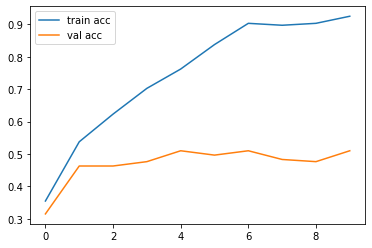

In [12]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

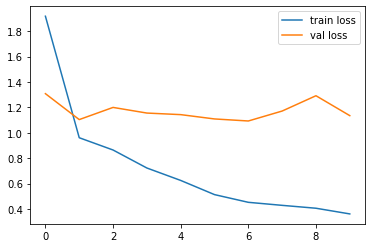

In [13]:
# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [14]:
test_y = test_y[1: len(test_y)]
model.evaluate(test_x,test_y,batch_size=32)

ValueError: Data cardinality is ambiguous:
  x sizes: 148
  y sizes: 147
Make sure all arrays contain the same number of samples.